In [1]:
import pandas as pd 
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import os

import seaborn as sns

from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, precision_score, ConfusionMatrixDisplay,mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, XGBRegressor

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform

pd.options.mode.copy_on_write = True

In [2]:
df = pd.read_csv(r"C:\Users\Usuario\Desktop\bootcamp-data-science\DS-Online-Alba-Rodriguez\Segundo_Proyecto_ML\dataset_definitivo.csv")
df

,MES_DENUNCIA,ANIO_DENUNCIA,MES_FIRMEZA,TIPO_ORGANISMO,CUANTIA,PUNTOS,SEXO,NOVEL,EDAD,TIPO_INFRACCION,PROVINCIA_TRAMITE,NUM_INFRACCIONES
0,1,2018,4,Ayuntamientos,200.0,3,V,NO,De 45 a 54 años,6.-Otros,Barcelona,1
1,1,2018,9,Ayuntamientos,200.0,3,M,NO,De 35 a 44 años,3.-Tlfn. móvil,Girona,1
2,1,2020,2,Ayuntamientos,200.0,3,V,NO,De 45 a 54 años,3.-Tlfn. móvil,Barcelona,1
3,1,2020,5,Ayuntamientos,200.0,4,V,NO,De 25 a 34 años,6.-Otros,Girona,1
4,1,2020,12,Ayuntamientos,200.0,3,V,NO,De 55 a 64 años,3.-Tlfn. móvil,Girona,1
...,...,...,...,...,...,...,...,...,...,...,...,...
315229,12,2023,12,Servei Catalán de Tráfico,500.0,6,V,NO,De 55 a 64 años,2.-Velocidad,Tarragona,1
315230,12,2023,12,Servei Catalán de Tráfico,500.0,6,V,NO,De 55 a 64 años,6.-Otros,Barcelona,1
315231,12,2023,12,Servei Catalán de Tráfico,500.0,6,V,NO,De 65 a 74 años,6.-Otros,Barcelona,1
315232,12,2023,12,Servei Catalán de Tráfico,500.0,6,V,SI,Hasta 24 años,6.-Otros,Girona,1


In [3]:
df = df.drop(columns= ["MES_DENUNCIA", "ANIO_DENUNCIA", "MES_FIRMEZA", "TIPO_ORGANISMO", "TIPO_INFRACCION", "PROVINCIA_TRAMITE"])  # Quitamos features que no influyen en la gravedad y otros que están tan realcionados que nos sobreajustaría el modelo
df

,CUANTIA,PUNTOS,SEXO,NOVEL,EDAD,NUM_INFRACCIONES
0,200.0,3,V,NO,De 45 a 54 años,1
1,200.0,3,M,NO,De 35 a 44 años,1
2,200.0,3,V,NO,De 45 a 54 años,1
3,200.0,4,V,NO,De 25 a 34 años,1
4,200.0,3,V,NO,De 55 a 64 años,1
...,...,...,...,...,...,...
315229,500.0,6,V,NO,De 55 a 64 años,1
315230,500.0,6,V,NO,De 55 a 64 años,1
315231,500.0,6,V,NO,De 65 a 74 años,1
315232,500.0,6,V,SI,Hasta 24 años,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315234 entries, 0 to 315233
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CUANTIA           315234 non-null  float64
 1   PUNTOS            315234 non-null  int64  
 2   SEXO              315234 non-null  object 
 3   NOVEL             315234 non-null  object 
 4   EDAD              315234 non-null  object 
 5   NUM_INFRACCIONES  315234 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 14.4+ MB


In [5]:
df.describe()

,CUANTIA,PUNTOS,NUM_INFRACCIONES
count,315234.000000,315234.000000,315234.000000
mean,383.352246,4.020978,3.341622
std,259.215915,1.447564,7.532732
min,0.000000,2.000000,1.000000
25%,200.000000,3.000000,1.000000
50%,300.000000,4.000000,1.000000
75%,500.000000,6.000000,3.000000
max,6000.000000,6.000000,304.000000


In [6]:
df.PUNTOS.value_counts()

PUNTOS
4    130169
6     87555
2     70987
3     26523
Name: count, dtype: int64

In [7]:
df["GRAVEDAD"] = (df["PUNTOS"] >= 4).astype(int)

# Si gravedad es mayor o igual que 4 = 1 (grave). Si gravedad menor o igual a 3 = 0 (no grave)
# 0 = no grave
# 1 = grave

In [8]:
df

,CUANTIA,PUNTOS,SEXO,NOVEL,EDAD,NUM_INFRACCIONES,GRAVEDAD
0,200.0,3,V,NO,De 45 a 54 años,1,0
1,200.0,3,M,NO,De 35 a 44 años,1,0
2,200.0,3,V,NO,De 45 a 54 años,1,0
3,200.0,4,V,NO,De 25 a 34 años,1,1
4,200.0,3,V,NO,De 55 a 64 años,1,0
...,...,...,...,...,...,...,...
315229,500.0,6,V,NO,De 55 a 64 años,1,1
315230,500.0,6,V,NO,De 55 a 64 años,1,1
315231,500.0,6,V,NO,De 65 a 74 años,1,1
315232,500.0,6,V,SI,Hasta 24 años,1,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315234 entries, 0 to 315233
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CUANTIA           315234 non-null  float64
 1   PUNTOS            315234 non-null  int64  
 2   SEXO              315234 non-null  object 
 3   NOVEL             315234 non-null  object 
 4   EDAD              315234 non-null  object 
 5   NUM_INFRACCIONES  315234 non-null  int64  
 6   GRAVEDAD          315234 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 16.8+ MB


In [10]:
target = "GRAVEDAD"

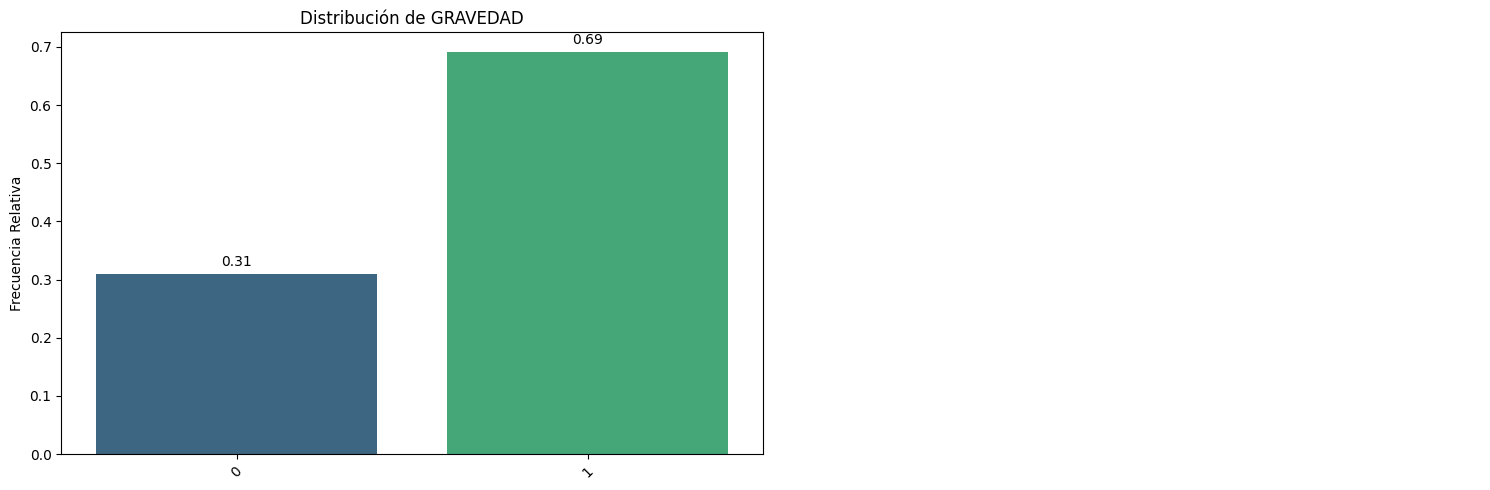

In [11]:
bt.pinta_distribucion_categoricas(df, [target], mostrar_valores = True, relativa = True)

In [12]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42, stratify=df["GRAVEDAD"])

In [13]:
corr = train_set.corr(numeric_only= "True")
serie_corr = np.abs(corr[target]).sort_values(ascending = False)
serie_corr

GRAVEDAD            1.000000
PUNTOS              0.808432
CUANTIA             0.287039
NUM_INFRACCIONES    0.100446
Name: GRAVEDAD, dtype: float64

In [14]:
# Convertimos la columna de SEXO en binaria 

pd.get_dummies(train_set["SEXO"], columns="SEXO", drop_first=True, dtype=int)

,V
103124,0
16281,1
29600,0
116042,1
177848,1
...,...
61344,1
291454,1
178534,0
118582,1


In [15]:

train_set["SEXO"] = (train_set["SEXO"] == "V").astype(int) # V -> clase 1, M -> clase 0
test_set["SEXO"] = (test_set["SEXO"] == "V").astype(int) # V -> clase 1, M -> clase 0

In [16]:
train_set["SEXO"].value_counts()

SEXO
1    174197
0     77990
Name: count, dtype: int64

In [17]:
# Convertimos la columna de NOVEL en binaria 

pd.get_dummies(train_set["NOVEL"], columns="NOVEL", drop_first=True, dtype=int)

,SI
103124,0
16281,0
29600,0
116042,0
177848,0
...,...
61344,0
291454,0
178534,0
118582,0


In [18]:
train_set["NOVEL"] = (train_set["NOVEL"] == "SI").astype(int) # SI -> clase 1, NO -> clase 0
test_set["NOVEL"] = (test_set["NOVEL"] == "SI").astype(int) # SI -> clase 1, NO -> clase 0

In [19]:
train_set["NOVEL"].value_counts()

NOVEL
0    239761
1     12426
Name: count, dtype: int64

In [20]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252187 entries, 103124 to 221009
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CUANTIA           252187 non-null  float64
 1   PUNTOS            252187 non-null  int64  
 2   SEXO              252187 non-null  int64  
 3   NOVEL             252187 non-null  int64  
 4   EDAD              252187 non-null  object 
 5   NUM_INFRACCIONES  252187 non-null  int64  
 6   GRAVEDAD          252187 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 15.4+ MB


In [21]:
df["EDAD"].value_counts()

EDAD
De 35 a 44 años    67131
De 25 a 34 años    66768
De 45 a 54 años    61598
De 55 a 64 años    44287
 Hasta 24 años     37512
De 65 a 74 años    24938
Más de 74 años     13000
Name: count, dtype: int64

In [22]:
# Aplicamos OE para la columna EDAD para otorgar un numero a cada rango de edad (en orden)

oe = OrdinalEncoder(categories=[[" Hasta 24 años", "De 25 a 34 años", "De 35 a 44 años", "De 45 a 54 años", "De 55 a 64 años", "De 65 a 74 años", "Más de 74 años"]])

train_set["EDAD"] = oe.fit_transform(train_set[["EDAD"]])
test_set["EDAD"] = oe.transform(test_set[["EDAD"]])

In [23]:
train_set["EDAD"] = train_set["EDAD"].astype(int)
test_set["EDAD"] = test_set["EDAD"].astype(int)
train_set["EDAD"].value_counts()

EDAD
2    53730
1    53389
3    49285
4    35395
0    29981
5    20056
6    10351
Name: count, dtype: int64

In [24]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252187 entries, 103124 to 221009
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CUANTIA           252187 non-null  float64
 1   PUNTOS            252187 non-null  int64  
 2   SEXO              252187 non-null  int64  
 3   NOVEL             252187 non-null  int64  
 4   EDAD              252187 non-null  int64  
 5   NUM_INFRACCIONES  252187 non-null  int64  
 6   GRAVEDAD          252187 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 15.4 MB


In [25]:
# Separo X e Y

X_train = train_set.drop(columns=["GRAVEDAD", "PUNTOS", "CUANTIA"])  # Quitamos las columnas que estan totalmente relacionadas con la gravedad para que no filtren información
y_train = train_set["GRAVEDAD"]

X_test = test_set.drop(columns=["GRAVEDAD", "PUNTOS", "CUANTIA"])
y_test = test_set["GRAVEDAD"]

In [26]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(252187, 4) (252187,)
(63047, 4) (63047,)


In [27]:
# Escalamos para que funcione bien KNN y vemos cual es su CV en recall

from sklearn.pipeline import Pipeline

knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=10, weights='distance'))
])

cv_recall = np.mean(
    cross_val_score(
        knn,
        X_train,
        y_train,
        cv=5,
        scoring='recall'
    )
)

print("CV recall:", cv_recall)

CV recall: 0.8202368901055669


In [28]:
# Entrenamos el modelo (aun sin mejorar sus hiperparámetros)

knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.47      0.28      0.35     19502
           1       0.73      0.86      0.79     43545

    accuracy                           0.68     63047
   macro avg       0.60      0.57      0.57     63047
weighted avg       0.65      0.68      0.65     63047



In [29]:
# Instanciamos modelos para comparar como es el CV de los demás

lr_clf = LogisticRegression(max_iter = 1000, class_weight = "balanced")
rf_clf = RandomForestClassifier(n_estimators=300, max_depth = 10, random_state= 42, n_jobs=-1, class_weight = "balanced")
lgb_clf = LGBMClassifier(n_estimators= 500, learning_rate= 0.05, num_leaves= 31, random_state= 42, n_jobs= -1, verbose= -1, class_weight = "balanced")

modelos_clf = {
    "Regresion Logistica": lr_clf,
    "Random Forest": rf_clf,
    "LightGBM": lgb_clf
}

In [30]:
for tipo,modelo in modelos_clf.items():
        print(f"{tipo}: ", end = " ")
        print(np.mean(cross_val_score(modelo, X_train, y_train, cv = 5, scoring = "recall")))

Regresion Logistica:  0.600514417302124
Random Forest:  0.6992863370471983
LightGBM:  0.7009742686858834


### Vamos a mejorar los hiperparametros de KNN porque hemos visto que es el que mejor resultados nos ha dado 

In [31]:
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance']
}

grid_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

grid_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn',
                                        KNeighborsClassifier(n_neighbors=10,
                                                             weights='distance'))]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 5, 7, 9, 11],
                         'knn__weights': ['uniform', 'distance']},
             scoring='recall')

In [32]:
print("Mejor CV recall:", grid_knn.best_score_)
print("Mejores params:", grid_knn.best_params_)

Mejor CV recall: 0.8825347794236178
Mejores params: {'knn__n_neighbors': 11, 'knn__weights': 'uniform'}


In [33]:
best_knn = grid_knn.best_estimator_

y_pred = best_knn.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.21      0.30     19502
           1       0.72      0.91      0.80     43545

    accuracy                           0.69     63047
   macro avg       0.62      0.56      0.55     63047
weighted avg       0.66      0.69      0.65     63047



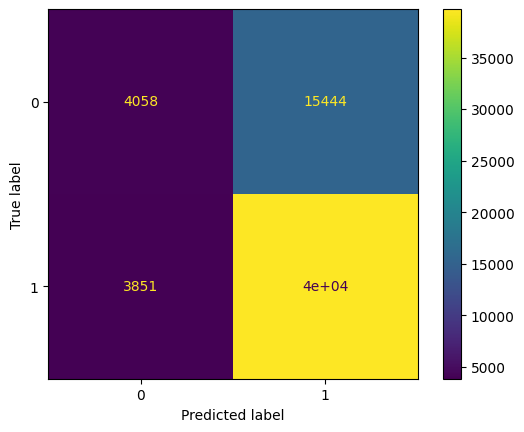

In [34]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

plt.show()

### El segundo mejor modelo es LightGBM asi que mejoramos sus hiperparámetros

In [35]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [36]:
# Modelo sencillo sin ajustar todos los hiperparametros de LightGBM

from sklearn.metrics import recall_score, f1_score, classification_report

lgb_base = LGBMClassifier(
    class_weight="balanced",   
    random_state=42,
    n_jobs=-1,
    verbose=-1)

lgb_base.fit(X_train, y_train)
y_pred = lgb_base.predict(X_test)

print("Recall test:", recall_score(y_test, y_pred))
print("F1 test:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Recall test: 0.6947295900792284
F1 test: 0.7236887745948208
              precision    recall  f1-score   support

           0       0.42      0.50      0.46     19502
           1       0.76      0.69      0.72     43545

    accuracy                           0.63     63047
   macro avg       0.59      0.60      0.59     63047
weighted avg       0.65      0.63      0.64     63047



In [37]:
# Modelo con mejores hiperparámetros

lgb_clf = LGBMClassifier(
    random_state=42,
    verbose=-1,
    n_jobs=-1,
    class_weight="balanced"
)

param_distributions = {
    "n_estimators": randint(200, 900),       
    "learning_rate": uniform(0.01, 0.19),    
    "num_leaves": randint(16, 128),          
    "min_child_samples": randint(10, 150),   
    "max_depth": randint(-1, 21),           
    "subsample": uniform(0.7, 0.3),         
    "reg_alpha": uniform(0.0, 0.3),          
    "reg_lambda": uniform(0.0, 2.0)          
}



lgb_random = RandomizedSearchCV(
    estimator=lgb_clf,
    param_distributions=param_distributions,
    n_iter=40,         
    scoring="recall",
    cv=cv,
    n_jobs=1,           # Evita “doble paralelismo”
    verbose=2,
    random_state=42,
    
)

lgb_random.fit(X_train, y_train)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END learning_rate=0.08116262258099886, max_depth=13, min_child_samples=116, n_estimators=271, num_leaves=76, reg_alpha=0.1790550473839461, reg_lambda=0.8916655057071823, subsample=0.7299924747454009; total time=   0.7s
[CV] END learning_rate=0.08116262258099886, max_depth=13, min_child_samples=116, n_estimators=271, num_leaves=76, reg_alpha=0.1790550473839461, reg_lambda=0.8916655057071823, subsample=0.7299924747454009; total time=   0.8s
[CV] END learning_rate=0.08116262258099886, max_depth=13, min_child_samples=116, n_estimators=271, num_leaves=76, reg_alpha=0.1790550473839461, reg_lambda=0.8916655057071823, subsample=0.7299924747454009; total time=   0.9s
[CV] END learning_rate=0.08116262258099886, max_depth=13, min_child_samples=116, n_estimators=271, num_leaves=76, reg_alpha=0.1790550473839461, reg_lambda=0.8916655057071823, subsample=0.7299924747454009; total time=   1.0s
[CV] END learning_rate=0.08116262258099886

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LGBMClassifier(class_weight='balanced', n_jobs=-1,
                                            random_state=42, verbose=-1),
                   n_iter=40, n_jobs=1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000023C06091160>,
                                        'max_depth': <scipy.stats._distn_infrastructur...
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023C05F40050>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000023C05F40690>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000023C7D803BB0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000023C05F40410>},
                   random_state=42, scoring='recall', verbose=2)

In [38]:
print("Mejores params:", lgb_random.best_params_)
print("Mejor recall (CV):", lgb_random.best_score_)

Mejores params: {'learning_rate': np.float64(0.06311646494138413), 'max_depth': 4, 'min_child_samples': 108, 'n_estimators': 236, 'num_leaves': 39, 'reg_alpha': np.float64(0.09922509140115411), 'reg_lambda': np.float64(1.1055299336709798), 'subsample': np.float64(0.8716877407512514)}
Mejor recall (CV): 0.7068589933914624


In [39]:
best_model = lgb_random.best_estimator_

In [40]:
best_model = lgb_random.best_estimator_
best_model.fit(X_train, y_train)  

y_proba = best_model.predict_proba(X_test)[:, 1]

for t in [0.2, 0.25, 0.3, 0.35, 0.4, 0.5]:
    y_t = (y_proba >= t).astype(int)
    print(
        f"t={t:0.2f}",
        "recall:", round(recall_score(y_test, y_t), 3),
        "f1:", round(f1_score(y_test, y_t), 3)
    )


t_final = 0.35
y_pred_final = (y_proba >= t_final).astype(int)
print(classification_report(y_test, y_pred_final))

t=0.20 recall: 0.991 f1: 0.82
t=0.25 recall: 0.977 f1: 0.821
t=0.30 recall: 0.954 f1: 0.819
t=0.35 recall: 0.931 f1: 0.815
t=0.40 recall: 0.887 f1: 0.803
t=0.50 recall: 0.706 f1: 0.729
              precision    recall  f1-score   support

           0       0.57      0.21      0.30     19502
           1       0.72      0.93      0.81     43545

    accuracy                           0.71     63047
   macro avg       0.65      0.57      0.56     63047
weighted avg       0.68      0.71      0.66     63047



In [41]:
# De cada 100 accidentes graves reales, el modelo detecta 93
# Solo se le escapan 7

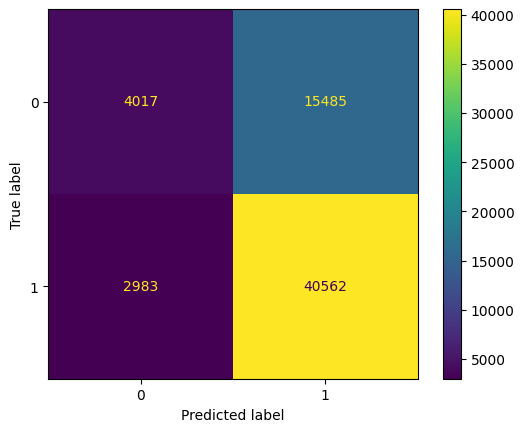

In [42]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_final)

plt.show()